In [1]:
from foreduce.data.data import GraphDataset

dataset = GraphDataset.load('./gnn/dataset.pt')

/home/apluska/foreduce/foreduce/data/data.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  max_arity, data = torch.load(path)


In [2]:
len(dataset)

15048

In [3]:
sum([d.num_nodes for d in dataset]) / len(dataset)

6704.568381180224

In [11]:
#count the number of graphs with less than 10 nodes
sum([1 for d in dataset if d.num_nodes < 10])

32

### Node number distribution of the dataset

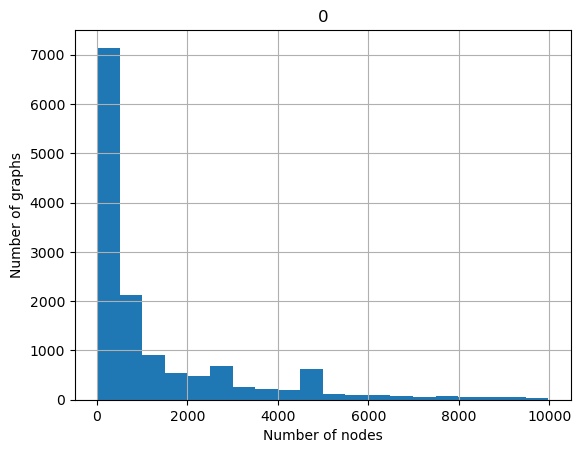

In [13]:
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the distribution of the number of nodes in the graphs
DataFrame([d.num_nodes for d in dataset if d.num_nodes < 10000]).hist(bins=20)
plt.xlabel('Number of nodes')
plt.ylabel('Number of graphs')
plt.show()

In [1]:
VAMPIRE_PATH = '/home/apluska/.vampire/bin/vampire_z3_rel_static_casc2023_6749'
TPTP_PATH = '/home/apluska/TPTP-v8.2.0/'

In [2]:
from foreduce.vampire.vampire import VampireAutomatic

vampire = VampireAutomatic(
    VAMPIRE_PATH,
    TPTP_PATH + "/Problems/PUZ/PUZ001-1.p",
    activation_limit=64,
)
vampire.run()
graph, mapping, clauses, labels = vampire.problem.to_graph_data(vampire.tree, limit=25)

In [3]:
from foreduce.data.data import GraphDataset

data = GraphDataset(8)
for i in range(50):
    data.add_proof(vampire.problem, vampire.tree, limit=i+10)

In [14]:
from torch_geometric.loader import DataLoader

loader = DataLoader(data, batch_size=1, shuffle=True)

In [7]:
from foreduce.transformer.model import GraphModel

model = GraphModel(8, 8, 8, 8)

/home/apluska/miniconda3/envs/foreduce/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
for batch in loader:    
    model.training_step(batch, None)

In [ ]:
import json
import torch
from sortedcontainers import SortedList

from foreduce.transformer.embedding import FormulaEmbedding
from foreduce.transformer.tokenizer import TokenConfig
from foreduce.vampire.vampire import VampireInteractive

problem = 'GRP/GRP002-1.p'

config = TokenConfig.from_dict(json.load(open('overfit/' + problem + '/config.json')))
mapping = json.load(open('overfit/' + problem + '/mapping.json'))
embedding = FormulaEmbedding.load_from_checkpoint('overfit/' + problem + '/model.ckpt')
    
goal = torch.tensor([mapping['<START>'], mapping['$false'], mapping['<END>']] + [mapping['<PAD>']] * (24 - 3), dtype=torch.long)
goal_embedding = embedding(goal.unsqueeze(0))

with VampireInteractive(VAMPIRE_PATH, 'overfit/' + problem + '/problem.p') as interactive:
    seen = 0
    similarities = SortedList()
    premise_count = []
    
    while not interactive.finished and interactive.step_count < 256:
        new_clauses = interactive.problem.clauses[seen:]
        if new_clauses:
            tokens = [clause.tokenize(config, mapping) for clause in new_clauses]
            __x = torch.zeros((len(new_clauses), args.seq_len), dtype=torch.long)
            for i, clause in enumerate(tokens):
                for j, token in enumerate(clause[:24]):
                    __x[i, j] = clause[j]
            with torch.no_grad():
                sim = torch.nn.functional.cosine_similarity(embedding(__x), goal_embedding, dim=-1)
            
            for i, (s, prev) in enumerate(zip(sim, interactive.tree[seen:])):
                premise_count.append(1 + sum(premise_count[idx] for idx in prev))
                similarities.add((s.item() / premise_count[-1]**0.5, seen + i))
                
            sim.detach()
            
            seen = len(interactive.problem.clauses)
        
        next_clause = similarities.pop(-1)[1]
        interactive.step(next_clause)
    
    with open('overfit/' + problem + '/overfit_proof.p', 'w') as f:
        f.write(interactive.proof)

In [ ]:
import os
from tqdm.auto import tqdm

from foreduce.tptp.parser import read_file as read_tptp

symbols = set()

for problem in tqdm(os.listdir(TPTP_PATH + 'Problems/GRP')):
    with open('problems/' + problem, 'w') as f:
        try:
            problem = read_tptp(TPTP_PATH + 'Problems/GRP/' + problem, include_path=TPTP_PATH, max_size=10_000)
            f.write(problem.to_tptp())
            symbols.update(problem.function_symbols() | problem.predicate_symbols())
        except:
            pass
    

/home/apluska/miniconda3/envs/foreduce/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1238/1238 [00:10<00:00, 114.82it/s]


In [ ]:
from collections import defaultdict
import json

from foreduce.transformer.tokenizer import TokenConfig

arity_dict = defaultdict(list)

for s in symbols:
    arity_dict[s.arity].append(s.name)

arity_list = list(arity_dict.values())
config = TokenConfig(num_functions=[len(s) for s in arity_list])
if os.path.exists('mapping.json'):
    with open('mapping.json') as f:
        function_mapping = json.load(f)
else:
    function_mapping = config.random_function_mapping(arity_list)
mapping = config.reserved_token_mapping | config.random_function_mapping(arity_list)
with open('mapping.json', 'w') as f:
    json.dump(mapping, f)

In [ ]:
from foreduce.vampire.vampire import VampireAutomatic
from foreduce.data.data import ProofTokens

if os.path.exists('dataset.pt'):
    dataset = ProofTokens.from_file('new_dataset.pt')
else:
    dataset = ProofTokens(config, seq_len=64)
    for problem in tqdm(os.listdir('problems')):
        vampire = VampireAutomatic(VAMPIRE_PATH, 'problems/' + problem) 
        try:
            vampire.run()
            with open('proofs/' + problem, 'w') as f:
                f.write(vampire.proof)
            if 'Refutation found' in vampire.proof:    
                dataset.add_proof(vampire.problem, vampire.tree, mapping)
        except:
            continue

    dataset.to_file('dataset.pt')

In [ ]:
from foreduce.transformer.embedding import FormulaEmbedding
from torch.utils.data import DataLoader
import torch

embedding = FormulaEmbedding(config, seq_len=64, dim=512, n_layers=8, n_heads=8)
train_val_split = int(0.8 * len(dataset))
train_sampler = torch.utils.data.SubsetRandomSampler(range(100_000_000))
val_sampler = torch.utils.data.SubsetRandomSampler(range(100_000_000, 110_000_000))
train_loader = DataLoader(dataset, batch_size=128, num_workers=4, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=128, num_workers=4, sampler=val_sampler)

In [ ]:
from lightning import Trainer
import wandb
from lightning.pytorch.loggers import WandbLogger
import torch

torch.set_float32_matmul_precision('medium')

wandb.init(project='foreduce')

trainer = Trainer(max_epochs=1, logger=WandbLogger(), accumulate_grad_batches=8, log_every_n_steps=1, val_check_interval=0.1)

trainer.fit(embedding, train_loader, val_loader)

wandb.finish()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lexpk. Use `wandb login --relogin` to force relogin


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/apluska/miniconda3/envs/foreduce/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | embeddings | Embedding  | 141 K  | train
1 | layers     | ModuleList | 16.8 M | train
2 | out        | Linear     | 262 K  | train
---------------------------

Epoch 0:  19%|█▉        | 147255/781250 [6:51:25<29:31:23,  5.97it/s, v_num=9r8l, train_loss_step=0.0037, val_loss_step=0.00222, val_loss_epoch=0.0022] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
embedding = embedding.cuda().eval()

In [ ]:
import torch

x = torch.zeros((len(vampire.problem.clauses), 32), dtype=torch.long)

for i, clause in enumerate(vampire.problem.clauses):
    tokens = vampire.problem.clauses[i].tokenize(config, mapping)
    for j, token in enumerate(tokens):
        x[i, j] = tokens[j]

NameError: name 'vampire' is not defined

In [ ]:
_x = embedding(x.cuda())
similarities = sorted([
    (
        i,
        torch.nn.functional.cosine_similarity(_x[i], _x[-1], dim=0).item()
    )
    for i in range(len(vampire.problem.clauses))
], key=lambda x: x[1], reverse=True)

for i, sim in similarities:
    print(f"{sim:.2f}", vampire.problem.clauses[i])

1.00 $false
0.60 product(X18, X19, X20) | ~product(X18, multiply(X19, X20), identity)
0.58 b = b
0.57 product(X39, X40, X41) | ~product(X39, multiply(X40, identity), X41)
0.56 product(c, X0, X1) | ~product(multiply(b, a), X0, X1)
0.56 product(c, b, a)
0.56 product(c, b, a)
0.56 product(c, b, a)
0.56 product(X9, a, c) | ~product(X9, b, identity)
0.56 product(X9, identity, c) | ~product(X9, multiply(b, a), identity)
0.56 product(X4, c, X5) | ~product(X4, multiply(b, a), X5)
0.56 product(X15, c, X16) | ~product(X15, multiply(b, a), X16)
0.56 product(X13, c, identity) | ~product(X13, multiply(b, a), identity)
0.56 product(X14, c, identity) | ~product(X14, multiply(b, a), identity)
0.56 c = multiply(multiply(b, a), identity)
0.56 product(X8, a, identity) | ~product(X8, b, c)
0.56 a = X1 | ~product(b, c, X1)
0.56 product(b, c, a)
0.56 product(b, c, a)
0.56 product(b, c, a)
0.55 product(c, a, b)
0.55 product(X2, X3, c) | ~product(multiply(b, a), X3, X2)
0.55 ~product(X5, identity, X6) | produ

In [ ]:
import torch

goal = torch.zeros(32, dtype=torch.long)
for i, token in enumerate(vampire.problem.clauses[-1].tokenize(config, mapping)):
    goal[i] = token

In [ ]:
from sortedcontainers import SortedList

from foreduce.vampire.vampire import VampireInteractive

MAX_STEP = 100

goal_embedding = embedding(goal.cuda().unsqueeze(0))

with VampireInteractive(VAMPIRE_PATH, './problem.p') as interactive:
    seen = 0
    similarities = SortedList()
    premise_count = []
    
    while not interactive.finished and interactive.step_count < MAX_STEP:
        new_clauses = interactive.problem.clauses[seen:]
        if new_clauses:
            tokens = [clause.tokenize(config, mapping) for clause in new_clauses]
            x = torch.zeros((len(new_clauses), 32), dtype=torch.long)
            for i, clause in enumerate(tokens):
                for j, token in enumerate(clause[:32]):
                    x[i, j] = clause[j]
            with torch.no_grad():
                sim = torch.nn.functional.cosine_similarity(embedding(x.cuda()), goal_embedding, dim=-1)
            
            for i, (s, p) in enumerate(zip(sim, interactive.tree[seen:])):
                premise_count.append(1 + sum(premise_count[idx] for idx in p))
                similarities.add((s.item() / premise_count[-1]**0.5, seen + i))
                
            sim.detach()
            
            seen = len(interactive.problem.clauses)
        
        next_clause = similarities.pop(-1)[1]
        interactive.step(next_clause)

In [ ]:
len(interactive.active), similarities[-10:], [(i, count) for i, count in enumerate(premise_count) if i in [sim[1] for sim in similarities[-10:]]]

(625,
 [(0.11616641642511098, 196),
  (0.1174590786298116, 240),
  (0.11798497662597299, 98),
  (0.11846662581597414, 379),
  (0.11889093615774611, 377),
  (0.12087865670522054, 428),
  (0.12129231293996175, 436),
  (0.12311546940861975, 554),
  (0.12383281886815857, 383),
  (0.1514881794176223, 601)],
 [(98, 13),
  (196, 19),
  (240, 9),
  (377, 13),
  (379, 11),
  (383, 11),
  (428, 9),
  (436, 9),
  (554, 11),
  (601, 7)])

In [ ]:
from itertools import chain

dependencies = []
for i, p in enumerate(vampire.tree):
    dependencies.append([i] + list(chain(*[dependencies[idx] for idx in p])))

In [ ]:
for i in dependencies[-1]:
    print(f"{torch.nn.functional.cosine_similarity(_x[i], goal_embedding, dim=-1).item() / len(dependencies[i]) ** 0.5:.2f}", vampire.problem.clauses[i])

0.18 $false
0.10 product(b, a, c)
0.27 product(X5, X6, multiply(X5, X6))
0.11 c = multiply(b, a)
0.12 product(multiply(b, a), identity, c)
0.13 product(multiply(b, a), c, identity)
0.21 product(multiply(X2, X3), X3, X2)
0.13 product(X0, X1, X2) | ~product(X2, X1, X0)
0.17 ~product(X0, identity, X1) | product(X2, X3, X1) | ~product(X0, X3, X2)
0.21 product(X19, X20, X22) | ~product(X17, X21, X22) | ~product(X18, X20, X21) | ~product(X17, X18, X19)
0.21 product(X0, X0, identity)
0.20 product(X2, identity, X2)
0.27 product(X5, X6, multiply(X5, X6))
0.15 product(X11, c, identity) | ~product(X11, a, b)
0.18 product(X0, X1, identity) | ~product(X2, X3, X1) | ~product(X0, X2, X3)
0.21 product(X11, X15, X16) | ~product(X13, X14, X16) | ~product(X12, X14, X15) | ~product(X11, X12, X13)
0.21 product(X0, X0, identity)
0.22 product(a, b, c)
0.20 goal_0 | product(a, b, c)
0.20 ~goal_0
0.17 product(X0, identity, X1) | ~product(X0, X1, identity)
0.18 product(X4, X5, X6) | ~product(X7, X6, X5) | ~prod

In [ ]:
print(interactive)

 0: product(X0, X0, identity)
 1: goal_0 | product(a, b, c)
 2: goal_1 | ~product(b, a, c)
 3: product(identity, X1, X1)
 4: product(X2, identity, X2)
 5: product(inverse(X3), X3, identity)
 6: product(X4, inverse(X4), identity)
 7: product(X5, X6, multiply(X5, X6))
 8: X9 = X10 | ~product(X7, X8, X10) | ~product(X7, X8, X9)
 9: product(X11, X15, X16) | ~product(X13, X14, X16) | ~product(X12, X14, X15) | ~product(X11, X12, X13)
 10: product(X19, X20, X22) | ~product(X17, X21, X22) | ~product(X18, X20, X21) | ~product(X17, X18, X19)
 11: ~goal_0
 12: ~goal_1
 13: c = X0 | ~product(a, b, X0) | goal_0
 14: X1 = X2 | ~product(X2, identity, X1)
15: identity = X3 | ~product(X4, inverse(X4), X3)
16: identity = X5 | ~product(inverse(X6), X6, X5)
 17: product(X0, X1, c) | ~product(X2, b, X1) | ~product(X0, X2, a) | goal_0
 18: product(X3, X4, X5) | ~product(X6, identity, X4) | ~product(X3, X6, X5)
19: product(X7, X8, identity) | ~product(X9, inverse(X10), X8) | ~product(X7, X9, X10)
20: product

In [ ]:
[sim for sim in similarities if sim[1] == 28]

[(0.0704181765530348, 28)]